In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *

from annotation_utilities import *
from registration_utilities import *
from conversion import *

Setting environment for Gordon


No vtk


In [3]:
annotation_rootdir = '/home/yuncong/csd395/CSHL_labelings_v3/'

In [4]:
stack = 'MD590'

In [5]:
from pandas import read_hdf
fn = os.path.join(annotation_rootdir, stack, '%(stack)s_annotation_v3.h5' % {'stack':stack})
contour_df = read_hdf(fn, 'contours')

IOError: File /home/yuncong/csd395/CSHL_labelings_v3/MD590/MD590_annotation_v3.h5 does not exist

In [5]:
paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', 'SNC', 'SNR', '3N', '4N',
                    'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

In [6]:
downsample_factor = 32
xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
voxel_z_size = section_thickness / xy_pixel_distance_downsampled

In [20]:
# anchor_filename = DataManager.load_anchor_filename(stack)
# filename_to_section, section_to_filename = DataManager.load_sorted_filenames(stack)

In [14]:
anchor_filename = metadata_cache['anchor_fn'][stack]
sections_to_filenames = metadata_cache['sections_to_filenames'][stack]
filenames_to_sections = {f: s for s, f in sections_to_filenames.iteritems() 
                        if f not in ['Placeholder', 'Nonexisting', 'Rescan']}

In [16]:
import cPickle as pickle
Ts = pickle.load(open('/home/yuncong/CSHL_data_processed/%(stack)s/%(stack)s_elastix_output/%(stack)s_transformsTo_anchor.pkl' % dict(stack=stack), 'r'))

Ts_inv_downsampled = {}
for fn, T0 in Ts.iteritems():
    T = T0.copy()
    T[:2, 2] = T[:2, 2] * 32 / downsample_factor
    Tinv = np.linalg.inv(T)
    Ts_inv_downsampled[fn] = Tinv

In [81]:
# Treat section as a single z value or a whole voxel slice.

In [20]:
def collect(matched_contours, convert_to='aligned'):
    """
    Convert matched annotation dataframe entries to contours as a list of 3d array.
    """
    
    contours_3d = []
    
    for cnt_id, cnt in matched_contours.iterrows():

        fn = cnt['filename']
        
        if fn not in filenames_to_sections:
            continue
            
        section = filenames_to_sections[fn]
        z = voxel_z_size * (section-1)

        if convert_to == 'aligned':
        
            n = len(cnt['vertices'])
            vertices_on_aligned = np.dot(Ts_inv_downsampled[fn], np.c_[cnt['vertices']/downsample_factor, np.ones((n,))].T).T[:, :2]

            vertices_on_aligned_3d = np.c_[vertices_on_aligned, z*np.ones((n,))]
            contours_3d.append(vertices_on_aligned_3d)
        
    return contours_3d

In [24]:
contours_grouped_by_name = {}

for name_u in singular_structures:
    print name_u
    
    matched_contours = contour_df[(contour_df['name'] == name_u)]
    if len(matched_contours) == 0:
        continue
    contours_3d = collect(matched_contours)
    contours_grouped_by_name[name_u] = contours_3d

for name_u in paired_structures:
    print name_u

    matched_contours = contour_df[(contour_df['name'] == name_u) & (contour_df['side'] == 'L')]
    if len(matched_contours) == 0:
        continue
    contours_3d = collect(matched_contours)
    contours_grouped_by_name[convert_to_left_name(name_u)] = contours_3d
    
    matched_contours = contour_df[(contour_df['name'] == name_u) & (contour_df['side'] == 'R')]
    if len(matched_contours) == 0:
        continue
    contours_3d = collect(matched_contours)
    contours_grouped_by_name[convert_to_right_name(name_u)] = contours_3d

AP
12N
RtTg
SC
IC
5N
6N
7N
7n
Amb
LC
LRt
Pn
Tz
VLL
RMC
SNC
SNR
3N
4N
Sp5I
Sp5O
Sp5C
PBG
10N
VCA
VCP
DC


In [11]:
# sec = 10
# random_tb_full_img = os.path.join(data_dir, stack, stack+'_thumbnail_sorted_aligned', stack+'_%04d_thumbnail_aligned.tif' % sec)
# tb_full_width, tb_full_height = map(int, check_output("identify -format %%Wx%%H %s" % random_tb_full_img, shell=True).split('x'))
# print tb_full_width, tb_full_height

In [26]:
name_s_to_label = {name_s: i+1 for i, name_s in enumerate(sorted(contours_grouped_by_name.keys()))}

In [27]:
contours_grouped_by_label = {name_s_to_label[name]: contours for name, contours in contours_grouped_by_name.iteritems()}

In [30]:
volume, (xmin,xmax,ymin,ymax,zmin,zmax) = contours_to_volume(contours_grouped_by_label=contours_grouped_by_label, 
                                                             interpolation_direction='z', return_shell=False)

print (xmin,xmax,ymin,ymax,zmin,zmax)

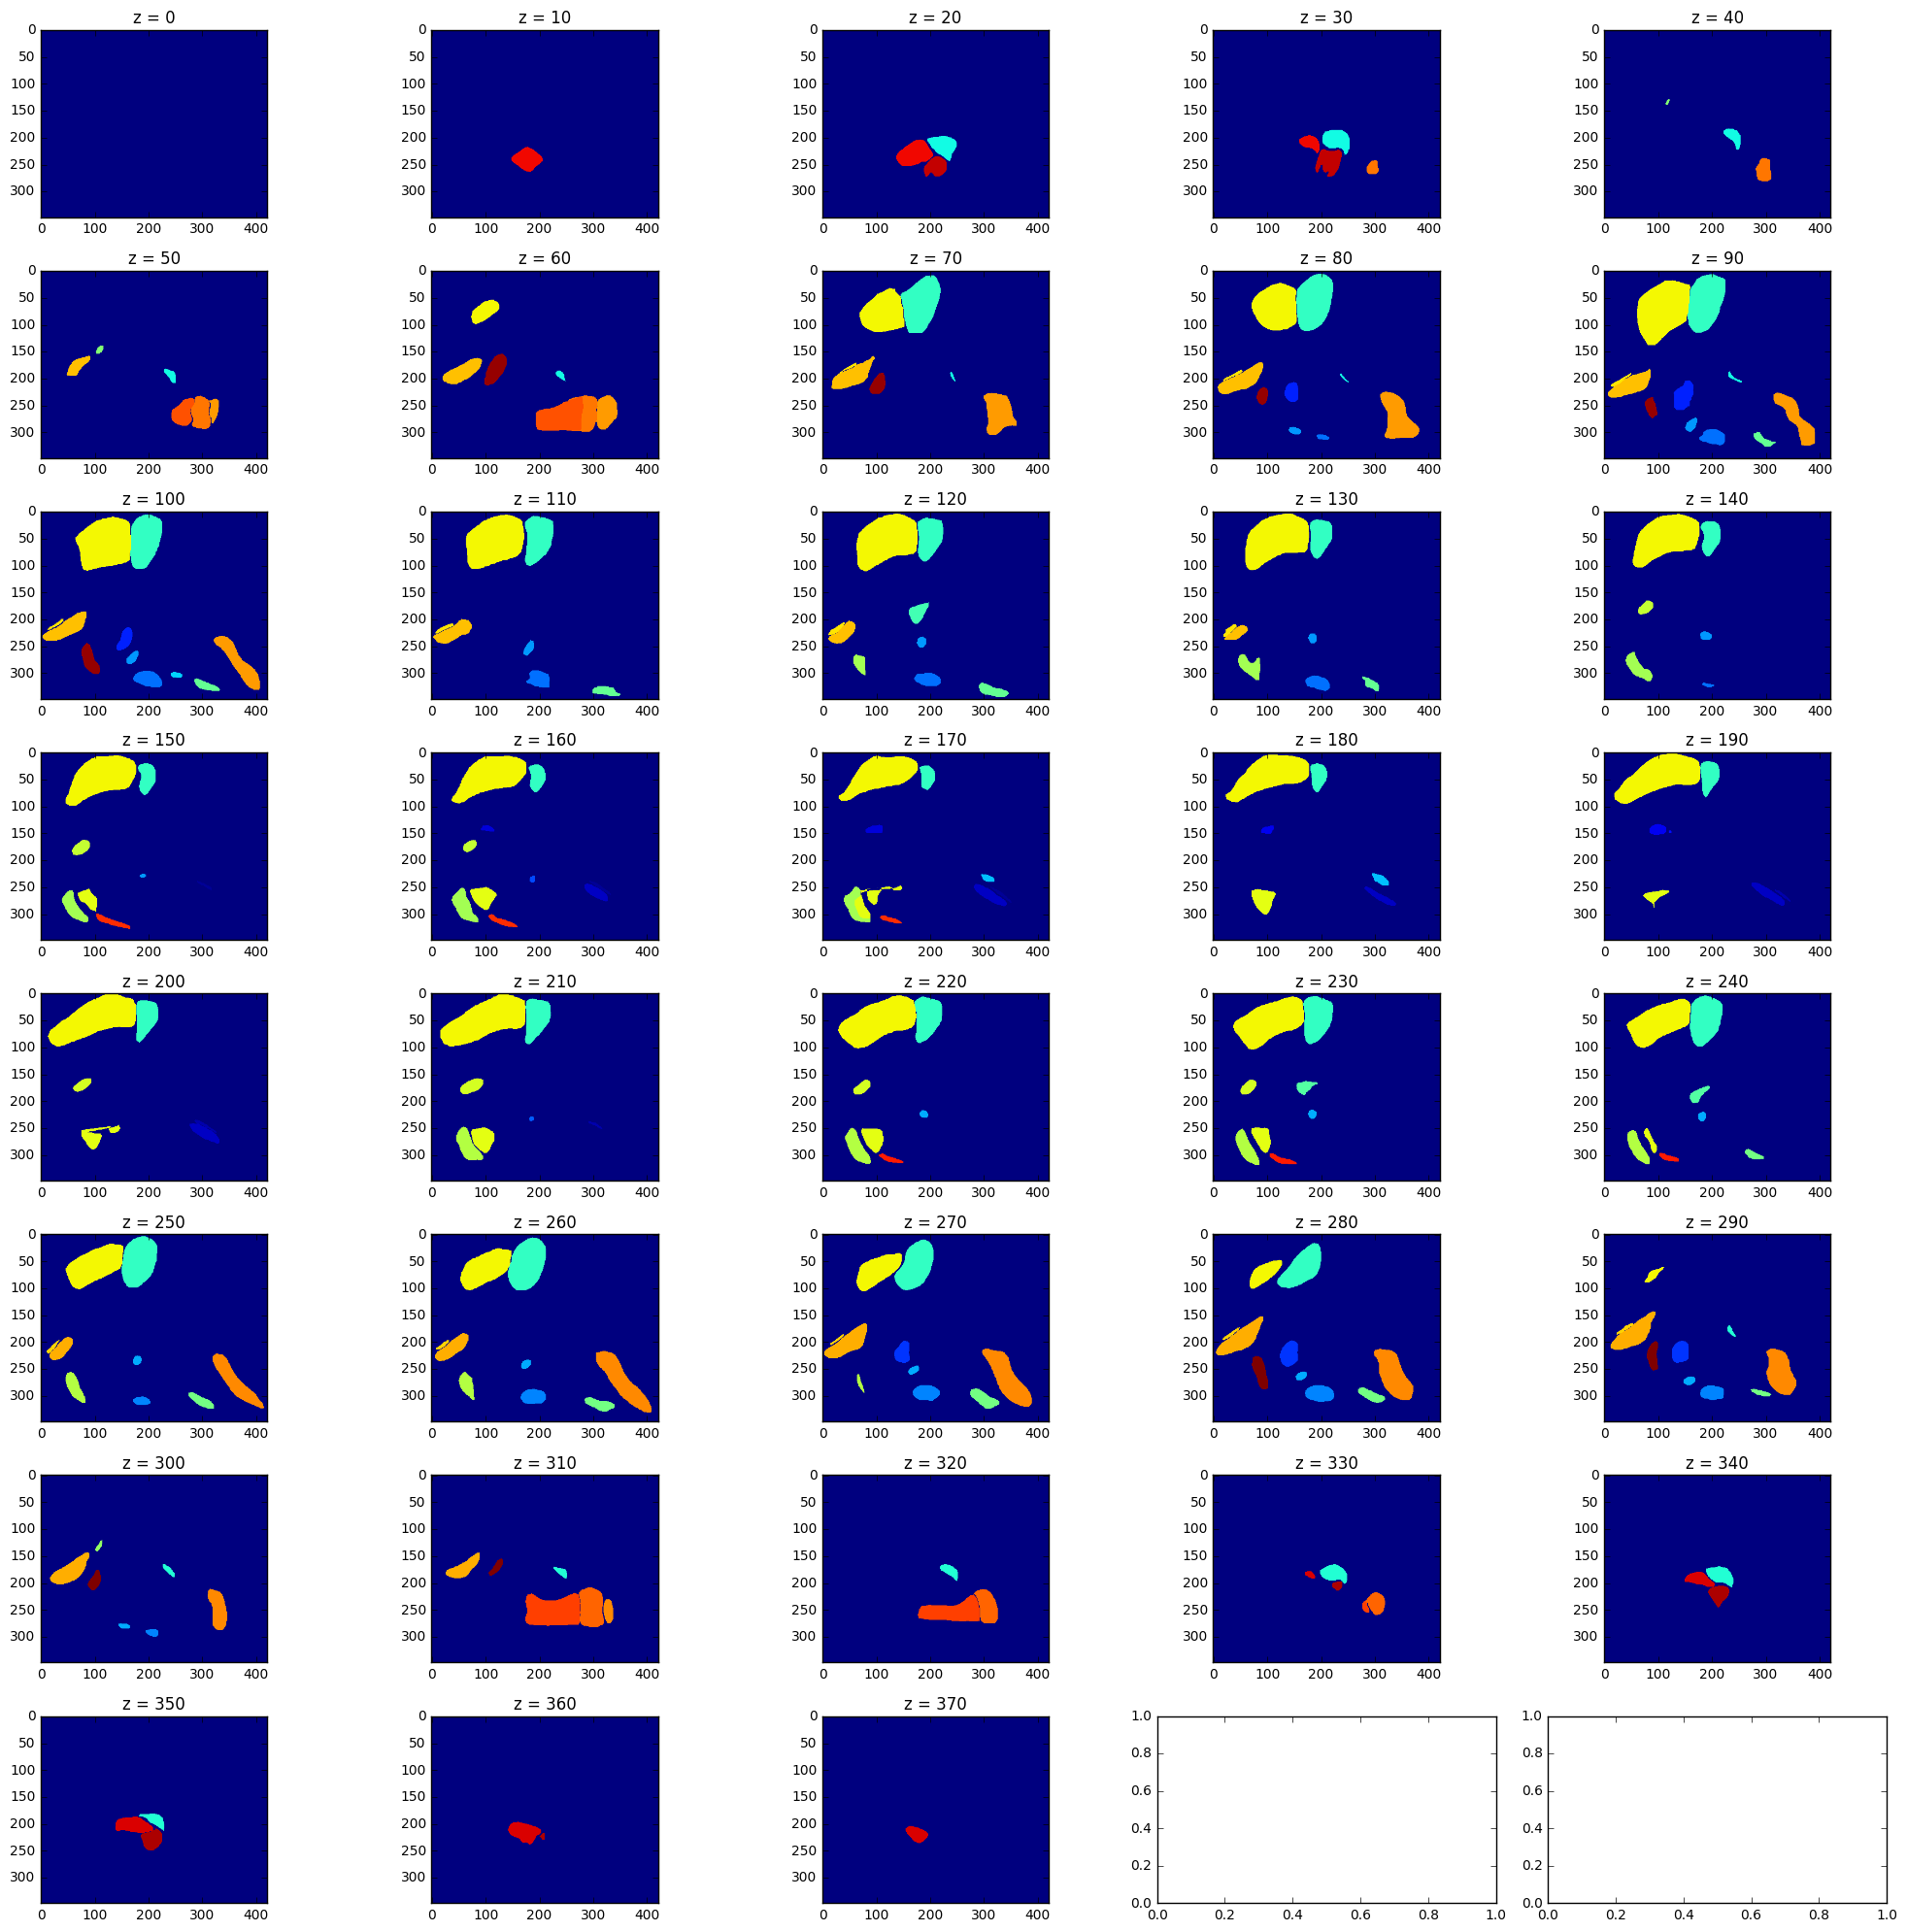

In [32]:
zs = range(0, volume.shape[2], 10)

fig, axes = plt.subplots(len(zs)/5+1, 5, figsize=(20,20) , squeeze=True);
axes = axes.flatten()
for i, z in enumerate(zs):
    axes[i].imshow(volume[..., z], vmin=0, vmax=np.max(name_s_to_label.values()));
    axes[i].set_title('z = %d' % z);
plt.tight_layout();
plt.show();

In [33]:
# Output

bp.pack_ndarray_file(volume, os.path.join(volume_dir, '%(stack)s/%(stack)s_down%(down)d_annotationVolume.bp' % \
                                          dict(down=downsample_factor, stack=stack)))

with open(os.path.join(volume_dir, '%(stack)s/%(stack)s_down%(down)d_annotationVolume_bbox.txt' % \
                      dict(down=downsample_factor, stack=stack)), 'w') as f:
        f.write((' '.join(['%d']*6)+'\n') % (xmin, xmax, ymin, ymax, zmin, zmax))
        
with open(os.path.join(volume_dir, '%(stack)s/%(stack)s_down%(down)d_annotationVolume_nameToLabel.txt' % \
                       dict(down=downsample_factor, stack=stack)), 'w') as f:
    for name_s, label in sorted(name_s_to_label.items()):
        f.write(name_s + ' ' + str(label) + '\n')

In [34]:
with open(os.path.join(volume_dir, '%(stack)s/%(stack)s_down%(down)d_annotationVolume_landmarkBboxes.txt' % \
                       dict(down=downsample_factor, stack=stack)), 'w') as f:
    for name_s, label in sorted(name_s_to_label.items()):
        bbox = bbox_3d(volume == label)
        f.write(name_s + ' ' + ' '.join(map(str, bbox)) + '\n')

In [ ]:
# Decompose as different volumes.

In [ ]:
volume = DataManager.load_annotation_volume(stack=stack, downscale=32)

print volume.shape

label_to_structure, structure_to_label = DataManager.load_volume_label_to_name(stack=stack)

vol_fixed_xmin, vol_fixed_xmax, vol_fixed_ymin, vol_fixed_ymax, vol_fixed_zmin, vol_fixed_zmax = \
DataManager.load_volume_bbox(stack=stack, type='annotation', downscale=32)

volume_decomposed = annotation_volume_to_score_volume(volume, label_to_structure)

for structure, v in volume_decomposed.iteritems():
    fp = DataManager.get_score_volume_filepath(stack=stack_fixed, downscale=32, structure=structure, volume_type='annotation_as_score')
    create_if_not_exists(os.path.dirname(fp))
    bp.pack_ndarray_file(v, fp)